# Test amplitude optimization component of matched filter

In [9]:
from GW_class import *
from template import waveform
import constants as c
import numpy as np

## Simulate data

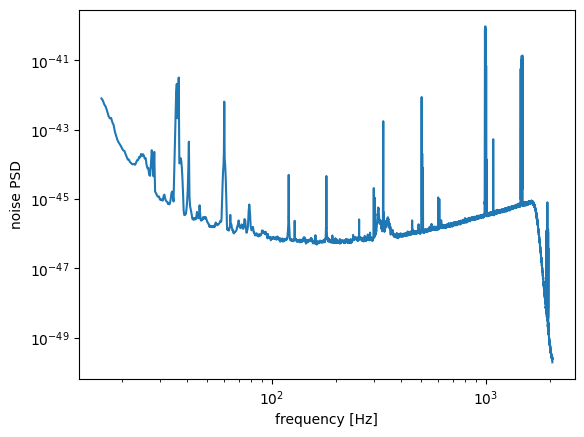

In [10]:
# get GW150914 estimated PSD
psd_func = GW_simulated.dictionary['large_data_psds']['H1']
psd = psd_func(c.freqs)
plt.loglog(c.freqs_for_waveform, psd_func(c.freqs_for_waveform))
plt.xlabel('frequency [Hz]')
plt.ylabel('noise PSD')
plt.show()

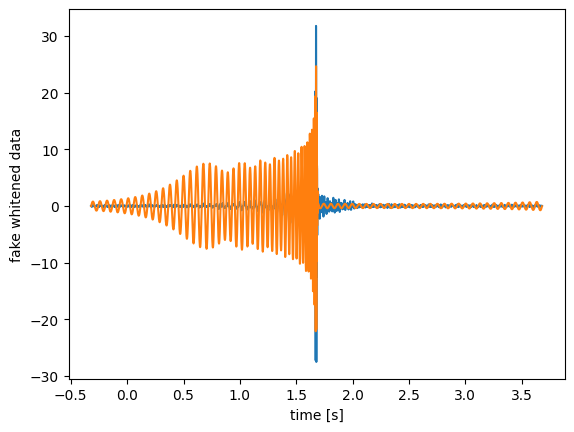

In [21]:
# choose some component parameters
comp_params = np.array([35.6, 30.6, -0.01, 0.0])

# make template in frequency-domain
template_FD = waveform.get_FD_waveform(comp_params, 0.)

# data is template multiplied by some "unknown" amplitude
random_amp = 40.3
data_FD = random_amp * template_FD
data_FD_whitened = data_FD / np.sqrt(psd_func(c.freqs))
data_TD = np.fft.irfft(data_FD, waveform.times_full.shape[0]) 
data_TD = np.roll(data_TD, data_TD.shape[0] // 2)
data_TD_whitened = np.fft.irfft(data_FD_whitened, waveform.times_full.shape[0]) 
data_TD_whitened = np.roll(data_TD_whitened, data_TD_whitened.shape[0] // 2)

# plot data
plt.plot(waveform.times_full, data_TD_whitened)
plt.plot(waveform.times_full, data_TD*10**23)
plt.xlabel('time [s]')
plt.ylabel('fake whitened data')
plt.show()

## Matched filter functions

In [12]:
# spacing between frequency bins
df = c.freqs[1] - c.freqs[0]

In [13]:
# noise weighted inner product
def inner(a, b):  # (a, b) are signals in frequency-domain
  
    #integrand = (a * b.conjugate()+ a.conjugate() * b)  /(psd)
    #this is what was changing
    #print(np.sum(a * (b.conjugate())))
    integrand = (2 * np.real(a * b.conjugate())) /psd
   
  
    return 4 * np.sum(integrand) * df

In [14]:
# normalize template

p_normalization_factor = np.sqrt(inner(template_FD, template_FD))

p = template_FD / p_normalization_factor

print(inner(p, p))


0.9999999999999998


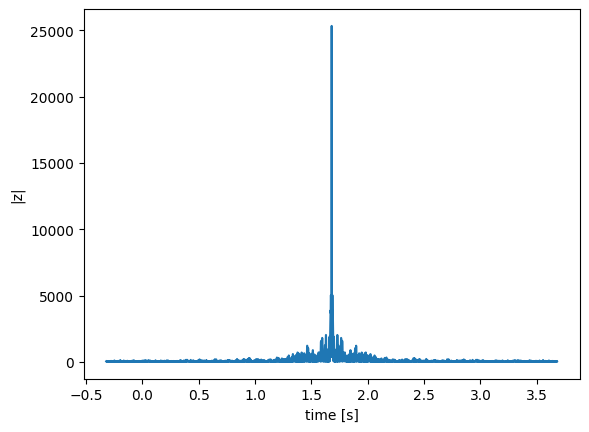

In [32]:
# times to search over for possible time shifts
times = np.linspace(waveform.times_full[0], waveform.times_full[-1], 16382)
# times = waveform.times_full


def get_SNR_time_series(template_FD, data_TD):
    data_FD = np.fft.rfft(data_TD) 
        
    #optimal_time = inner(data_fft, template_FD)

    optimal = data_FD * template_FD.conjugate() /psd
    optimal_time = 4 * np.fft.irfft(optimal) * fs

    z = optimal_time

    # COMPUTE COMPLEX SNR TIME SERIES
    # YOUR CODE HERE

    # return z
    return z


# plot complex SNR time series
z = get_SNR_time_series(p, data_TD)
# z = np.roll(z, 100000)
plt.plot(times, np.abs(z))
plt.xlabel('time [s]')
plt.ylabel('|z|')
plt.show()

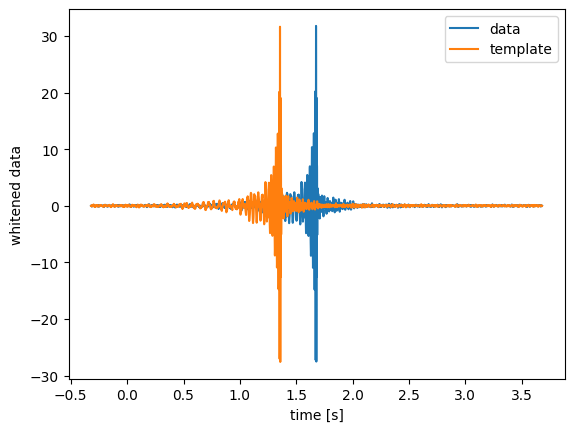

In [35]:
# placeholder for complex time series
#z = np.ones(times.shape[0])

# get optimal time-shift, phase, and amplitude
opt_ndx = np.argmax(np.abs(z))
opt_time_shift = times[opt_ndx]
opt_amplitude = np.abs(z)[opt_ndx]
opt_phase = np.angle(z[opt_ndx])

# optimal template in frequency-domain
# add time shift
opt_template_FD = opt_amplitude * p * np.exp(-2. * np.pi * 1.j * c.freqs * opt_time_shift)
# add frequency shift (may be INCORRECT!!!)
opt_template_FD *= np.exp(- 1.j * opt_phase)

# whiten template
opt_template_FD_whitened = opt_template_FD / np.sqrt(psd)

# optimal template in time-domain (whitened)
# need normalization constants?
opt_template_TD = np.fft.irfft(opt_template_FD_whitened, waveform.times_full.shape[0])

plt.plot(waveform.times_full, data_TD_whitened, label='data')
plt.plot(waveform.times_full, opt_template_TD, label='template')
# plt.xlim(1.5, 1.7)
plt.xlabel('time [s]')
plt.ylabel('whitened data')
plt.legend()
plt.show()